In [201]:
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw
from functools import reduce

In [202]:
def find_first_nonzero(ar):
    return np.min(np.nonzero(ar))

def find_last_nonzero(ar):
    return np.max(np.nonzero(ar)) + 1

def find_first_last_non_zero(ar):
    return find_first_nonzero(ar), find_last_nonzero(ar)

In [203]:
def convert_to_bd_image(image):
    image = np.array(image)
    return 1 - image / 255

In [204]:
def calc_horizontal_profile(image):
    return convert_to_bd_image(image).sum(axis=1)

def calc_vertical_profile(image):
    return convert_to_bd_image(image).sum(axis=0)

def calc_profiles(image):
    return calc_horizontal_profile(image), calc_vertical_profile(image)

In [205]:
def generate_font_images(font_path, font_size):
    letters = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя"
    font = ImageFont.truetype(font_path, font_size)

    for letter in letters:
        _, _, width, height = font.getbbox(letter)

        image = Image.new("L", (width, height), color="white")
        draw = ImageDraw.Draw(image)
        draw.text((0, 0), letter, font=font, color="black")

        horizontal_profile, vertical_profile = calc_profiles(image)

        upper, lower = find_first_last_non_zero(horizontal_profile)
        left, right = find_first_last_non_zero(vertical_profile)

        cropped_letter = image.crop((left, upper, right, lower))

        cropped_letter.save(f"font/{letter}.bmp")

In [206]:
def generate_phrase(phrase, font_path, font_size):
    font = ImageFont.truetype(font_path, font_size)

    width = reduce(
    lambda acc, curr: acc + curr,
    map(lambda symbol: font.getbbox(symbol)[2], phrase),
    0)

    height = max(map(lambda symbol: font.getbbox(symbol)[3], phrase))

    width_padding = 60
    height_padding = 20

    image = Image.new("L", (width + width_padding, height + height_padding), color="white")
    draw = ImageDraw.Draw(image)
    draw.text((width_padding // 2, height_padding // 2), phrase, font=font, color="black")
    image.save("output/phrase.bmp")

In [207]:
def find_symbol_ranges(vertical_profile, horizontal_threshold):
    ranges = []

    l = 0

    while l < vertical_profile.size:
        while l < vertical_profile.size and vertical_profile[l] == 0:
            l += 1

        r = l

        while r < vertical_profile.size and vertical_profile[r] != 0:
            r += 1

        if (l != r):
            ranges.append((l, r))

        l = r

    filtered_ranges = []

    for symbol_range in ranges:
        if len(filtered_ranges) == 0:
            filtered_ranges.append(symbol_range)
            continue

        if (symbol_range[0] - filtered_ranges[-1][1] < horizontal_threshold):
            filtered_ranges[-1] = (filtered_ranges[-1][0], symbol_range[1])
        else:
            filtered_ranges.append(symbol_range)
    
    return filtered_ranges

In [208]:
def find_boxes_from_ranges(image, ranges):
    boxes = []

    _, height = image.size

    for i, symbol_range in enumerate(ranges):
        left, right = symbol_range
        symbol = image.crop((left, 0, right, height))

        horizontal_profile = calc_horizontal_profile(symbol)

        width, _ = symbol.size

        lower, upper = find_first_last_non_zero(horizontal_profile)
        symbol = symbol.crop((0, lower, width, upper))

        boxes.append((left, lower, right, upper))

    return boxes


In [209]:
def segment_text(image, horizontal_threshold):
    _, vertical_profile = calc_profiles(image)
    
    ranges = find_symbol_ranges(vertical_profile, horizontal_threshold)
    boxes = find_boxes_from_ranges(image, ranges)

    return boxes

In [210]:
def calc_black_weight(bd_image):
    return np.sum(bd_image)

def calc_rel_black_weight(bd_image):
    return calc_black_weight(bd_image) / bd_image.size

def calc_center_of_gravity(bd_image):
    height, width = bd_image.shape

    black_weight = calc_black_weight(bd_image)

    center_x = (np.sum(bd_image, axis=1) @ np.array(range(height))) / black_weight
    center_y = (np.sum(bd_image, axis=0) @ np.array(range(width))) / black_weight

    return center_x, center_y

def calc_rel_center_of_gravity(bd_image):
    height, width = bd_image.shape

    center_x, center_y = calc_center_of_gravity(bd_image)

    return (center_x - 1) / (height - 1), (center_y - 1) / (width - 1)

def calc_horizontal_inertia_moment(bd_image):
    _, width = bd_image.shape
    _, y_center = calc_center_of_gravity(bd_image)

    return np.sum((np.array(range(width)) - y_center)**2 @ np.transpose(bd_image))

def calc_vertical_inertia_moment(bd_image):
    height, _ = bd_image.shape
    x_center, _ = calc_center_of_gravity(bd_image)
    return np.sum((np.array(range(height)) - x_center)**2 @ bd_image)

def calc_rel_horizontal_inertia_moment(bd_image):
    height, width = bd_image.shape

    return calc_horizontal_inertia_moment(bd_image) / (height**2 * width**2)

def calc_rel_vertical_inertia_moment(bd_image):
    height, width = bd_image.shape

    return calc_vertical_inertia_moment(bd_image) / (height**2 * width**2)

In [211]:
def create_features_report(symbols):
    report = {
        "Symbol": [],
        "Black Mass": [],
        "Center of Gravity, X": [],
        "Center of Gravity, Y": [],
        "Horizontal Moment of Inertia": [],
        "Vertical Moment of Inertia": [],

    }

    for symbol in symbols:
        image = Image.open(f"font/{symbol}.bmp")
        bd_image = convert_to_bd_image(image)

        x_center, y_center = calc_rel_center_of_gravity(bd_image)

        report["Symbol"].append(symbol)
        report["Black Mass"].append(calc_rel_black_weight(bd_image))
        report["Center of Gravity, X"].append(x_center)
        report["Center of Gravity, Y"].append(y_center)
        report["Horizontal Moment of Inertia"].append(calc_rel_horizontal_inertia_moment(bd_image))
        report["Vertical Moment of Inertia"].append(calc_rel_vertical_inertia_moment(bd_image))
    
    df = pd.DataFrame(report)

    return df

In [212]:
def normalize(value, params):
    col_min, col_max = params
    return (value - col_min) / (col_max - col_min)

def normalize_features(features):
    normalized_features = features.copy()

    feature_to_norm_params = dict()

    for column in normalized_features:
        if column == "Symbol":
            continue

        col_min = normalized_features[column].min()
        col_max = normalized_features[column].max()

        feature_to_norm_params[column] = col_min, col_max

        normalized_features[column] = (normalized_features[column] - col_min) / (col_max - col_min)
    
    return normalized_features, feature_to_norm_params


In [213]:
def predict_symbol(bd_symbol, feature_matrix, norm_params, symbols):
    x_center, y_center = calc_rel_center_of_gravity(bd_symbol)

    letter_features = np.array([
        normalize(calc_rel_black_weight(bd_symbol), norm_params["Black Mass"]),
        normalize(x_center, norm_params["Center of Gravity, X"]),
        normalize(y_center, norm_params["Center of Gravity, Y"]),
        normalize(calc_rel_horizontal_inertia_moment(bd_symbol), norm_params["Horizontal Moment of Inertia"]),
        normalize(calc_rel_vertical_inertia_moment(bd_symbol), norm_params["Vertical Moment of Inertia"]),
    ])

    distances = np.sqrt(np.sum((feature_matrix - letter_features)**2, axis=1))
    probs = np.exp(-distances)

    result = []

    for i, symbol in enumerate(symbols):
        result.append((symbol, probs[i]))

    return sorted(result, key=lambda x: -x[1])

In [214]:
symbols = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя"
phrase = "если жена мешает преферансу бросай жену"
phrase_path = "output/phrase.bmp"

In [215]:
generate_font_images("font/CaskaydiaMonoNerdFont-Regular.ttf", 69)
generate_phrase(phrase,
                "font/CaskaydiaMonoNerdFont-Regular.ttf",
                69)

In [216]:
features = create_features_report(symbols)
features.head(5)

,Symbol,Black Mass,"Center of Gravity, X","Center of Gravity, Y",Horizontal Moment of Inertia,Vertical Moment of Inertia
0,а,0.476704,0.522565,0.449716,0.029232,0.041093
1,б,0.478842,0.505396,0.444545,0.025082,0.060712
2,в,0.674808,0.475409,0.417008,0.051672,0.074522
3,г,0.386573,0.338518,0.271276,0.018498,0.048458
4,д,0.489763,0.478058,0.484684,0.032680,0.050794


In [217]:
norm_features, norm_params = normalize_features(features)
norm_features.head(5)

,Symbol,Black Mass,"Center of Gravity, X","Center of Gravity, Y",Horizontal Moment of Inertia,Vertical Moment of Inertia
0,а,0.400051,0.836654,0.599567,0.325318,0.241304
1,б,0.406525,0.772145,0.582193,0.236885,0.686566
2,в,1.000000,0.659475,0.489666,0.803481,1.000000
3,г,0.127094,0.145134,0.000000,0.096597,0.408454
4,д,0.439598,0.669427,0.717061,0.398782,0.461474


In [218]:
numeric_features = [
    "Black Mass",
    "Center of Gravity, X",
    "Center of Gravity, Y",
    "Horizontal Moment of Inertia",
    "Vertical Moment of Inertia"]

feature_matrix = norm_features[numeric_features].to_numpy()

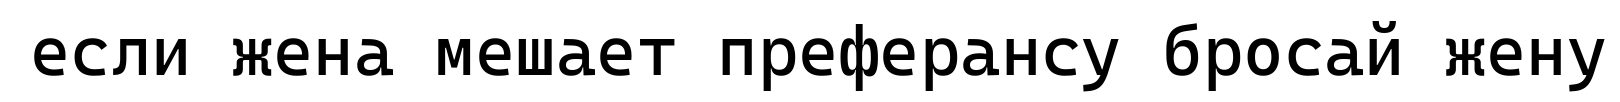

In [219]:
image = Image.open(phrase_path).convert("L")
image

In [220]:
boxes = segment_text(image, horizontal_threshold=3)

In [221]:
boxes = segment_text(image)
bd_image = convert_to_bd_image(image)

In [222]:
predictions = []

for box in boxes:
    left, lower, right, upper = box
    bd_symbol = bd_image[lower:upper, left:right]
    predictions.append(
        predict_symbol(bd_symbol, feature_matrix, norm_params, symbols))

In [223]:
phrase_without_ws = phrase.replace(" ", "")
predicted_phrase = ''.join(map(lambda x: x[0][0], predictions))

print(f"Expected: {phrase_without_ws}\nResult:   {predicted_phrase}")

Expected: еслиженамешаетпреферансубросайжену
Result:   еслиженамешаетпреферансубросайжену


In [224]:
count = 0

for predicted_symbol, symbol in zip(predicted_phrase, phrase_without_ws):
    count += predicted_symbol == symbol

correct_percentage = (count / len(phrase_without_ws)) * 100
print(f"Correct guesses: {correct_percentage}%") 

Correct guesses: 100.0%


In [225]:
with open("output/probs.txt", "w") as f:
    for i, prediction in enumerate(predictions):
        print(f"{i}: {prediction}", file=f)